## Import

In [1]:
# Импортируем наши стандартные библиотеки
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

%matplotlib inline
#sns.set()

## Furctions

In [2]:
def sk_model_cl(model, data, target, random_state=112358, stratify=False, test_size = 0.2, train=True, test=True, conf_m=True):
    """
    Predict on train and test, print metrics
    
    Keyword arguments:
    model : sklearn classifier
    data : X
    target : y
    stratify : stratify target
    train : print train metrics
    test : print test metrics
    conf_m : plot confusion matrix
    """  
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=random_state)
    model.fit(X_train, y_train)
    if train:
        pred_train = model.predict(X_train)
        print('TRAIN:')
        print(classification_report(y_train, pred_train))
        if conf_m:
            ConfusionMatrixDisplay.from_predictions(y_train, pred_train)
            plt.show()
    if test:
        pred_test = model.predict(X_test)
        print('TEST:')
        print(classification_report(y_test, pred_test))
        if conf_m:
            ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
            plt.show()
    
    return model

## Data

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')

In [4]:
df.sample(4)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
106,phon_R01_S25_4,155.078,163.736,144.148,0.00168,0.000010,0.00068,0.00092,0.00204,0.01064,...,0.01567,0.00233,29.746,1,0.334171,0.677930,-6.981201,0.184550,2.129924,0.106802
70,phon_R01_S18_5,142.729,162.408,65.476,0.00831,0.000060,0.00469,0.00419,0.01407,0.03485,...,0.05605,0.02599,20.264,1,0.489345,0.730387,-5.720868,0.158830,2.277927,0.180828
12,phon_R01_S04_1,136.926,159.866,131.276,0.00293,0.000020,0.00118,0.00153,0.00355,0.01259,...,0.01968,0.00581,25.703,1,0.460600,0.646846,-6.547148,0.152813,2.041277,0.138512
44,phon_R01_S10_3,243.439,250.912,232.435,0.00210,0.000009,0.00109,0.00137,0.00327,0.01419,...,0.02330,0.00454,25.368,0,0.438296,0.635285,-7.057869,0.091608,2.330716,0.091470


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [6]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


## Baseline

In [7]:
#lightGBM has some issues with special chars in column names
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
df.sample(4)

,name,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
77,phon_R01_S19_6,110.568,125.394,106.821,0.00462,0.00004,0.00226,0.00280,0.00677,0.02199,...,0.03852,0.00420,25.820,1,0.429484,0.816340,-5.391029,0.250572,1.777901,0.232744
172,phon_R01_S43_2,110.739,113.597,100.139,0.00356,0.00003,0.00170,0.00200,0.00510,0.01484,...,0.02261,0.00430,26.550,0,0.369090,0.776158,-6.085567,0.192375,1.889002,0.174152
27,phon_R01_S06_4,146.845,208.701,81.737,0.00496,0.00003,0.00250,0.00275,0.00749,0.01919,...,0.02650,0.01328,25.119,1,0.358773,0.726652,-6.271690,0.196102,2.314209,0.162999
50,phon_R01_S13_3,124.445,135.069,117.495,0.00431,0.00003,0.00141,0.00167,0.00422,0.02184,...,0.03724,0.00479,25.135,0,0.553134,0.775933,-6.650471,0.254498,1.840198,0.103561


In [9]:
X = df.drop(columns=["status", "name"])
y = df.status

TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       104

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



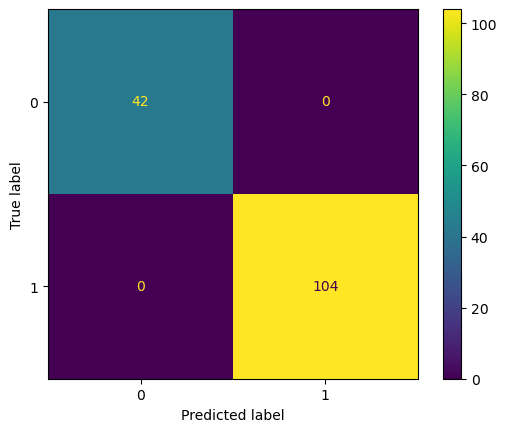

TEST:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.98      1.00      0.99        43

    accuracy                           0.98        49
   macro avg       0.99      0.92      0.95        49
weighted avg       0.98      0.98      0.98        49



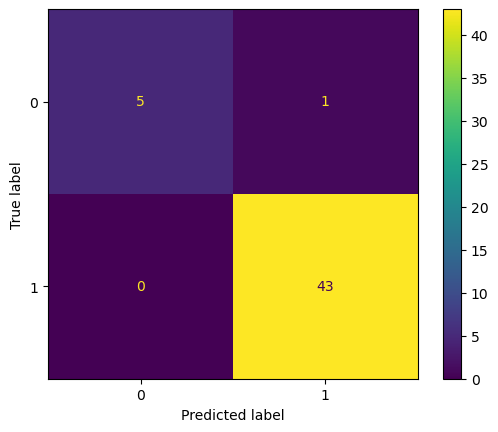

In [10]:
CB_model = sk_model_cl(cb.CatBoostClassifier(verbose=0), X, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

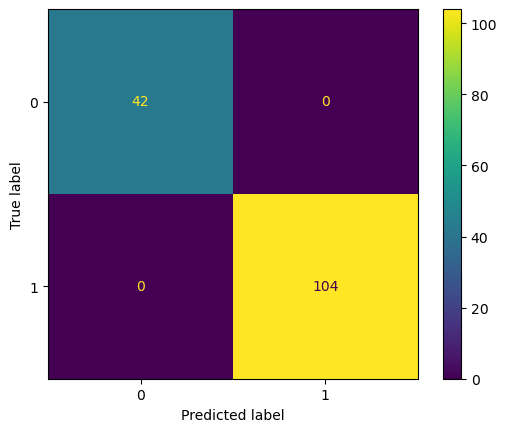

TEST:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.98      1.00      0.99        43

    accuracy                           0.98        49
   macro avg       0.99      0.92      0.95        49
weighted avg       0.98      0.98      0.98        49



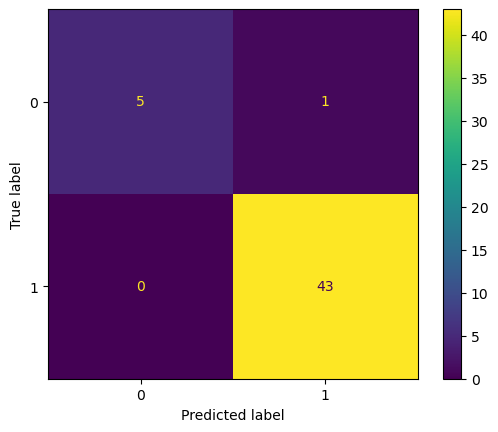

In [11]:
LGB_model = sk_model_cl(lgb.LGBMClassifier(verbose=0), X, y)

#### Feature importance

In [12]:
pd.Series(data=CB_model.feature_importances_, index=CB_model.feature_names_).sort_values(ascending=False)

spread2          12.618450
MDVPFoHz         10.756270
PPE              10.515428
MDVPFhiHz         9.589547
D2                7.845772
spread1           6.911466
DFA               6.273476
RPDE              4.158982
ShimmerAPQ3       3.489739
MDVPFloHz         3.201179
ShimmerDDA        3.182342
JitterDDP         2.885751
HNR               2.624978
MDVPRAP           2.338655
MDVPJitter        2.124529
MDVPAPQ           1.863997
ShimmerAPQ5       1.839377
NHR               1.726282
MDVPPPQ           1.699363
MDVPShimmerdB     1.523638
MDVPShimmer       1.459074
MDVPJitterAbs     1.371705
dtype: float64

In [13]:
pd.Series(data=LGB_model.feature_importances_, index=LGB_model.feature_name_).sort_values(ascending=False)

spread2          97
PPE              68
MDVPFoHz         64
MDVPFhiHz        57
RPDE             38
ShimmerAPQ3      35
DFA              31
D2               27
spread1          27
MDVPShimmerdB    25
HNR              19
MDVPShimmer      17
MDVPAPQ          16
JitterDDP        14
NHR              14
MDVPJitterAbs    11
MDVPRAP           9
MDVPJitter        8
MDVPPPQ           8
ShimmerAPQ5       7
MDVPFloHz         3
ShimmerDDA        2
dtype: int32

#### Random Search CV

Fitting 3 folds for each of 10 candidates, totalling 30 fits
TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       104

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



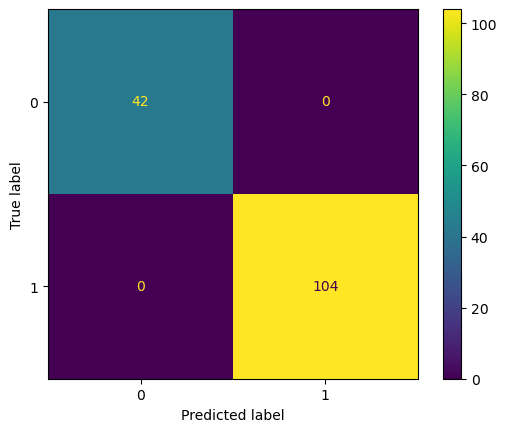

TEST:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.98      0.99        43

    accuracy                           0.98        49
   macro avg       0.93      0.99      0.96        49
weighted avg       0.98      0.98      0.98        49



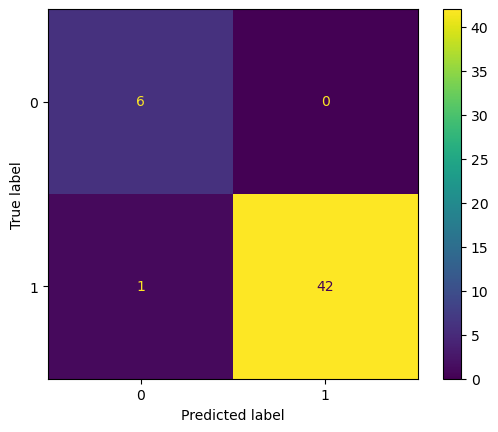

Wall time: 1min 12s


In [14]:
%%time

# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем f1_score

grid_CB = RandomizedSearchCV(
            cb.CatBoostClassifier(verbose=0),       # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'f1',    
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_CB = sk_model_cl(grid_CB, X, y)